# Data Science Smörgåsbord: Clustering
### Kori Thompson
Please note this is an exercise to get used to using and interpreting clustering models. Normally data would be broken into test and training datasets and the datasets would have much higher dimensionality. Low dimensionality was used to allow for data visualization of the clustering. Actual data science projects also involve more intensive data cleaning, preprocessing, and exploratory data analysis than this exercise.

Clustering algothrims are unsurvised machine learning algorithms. There are no labels for the data and the goal of the algorithm is to create lables or clusters of similar datapoints. Clustering can be used to create new features for datasets or to group, analyize, and identify patterns the dataset. This exercise explores 3 different clustering methods on the same two-dimensional dataset. The clustering methods used are K-Means clustering, Gaussian Mixture clustering, and DBSCAN clustering. For each model, the appropriate methods to choose the optimal number of clusters. 

In [ ]:
# data manipulation
import numpy as np
import pandas as pd
# data visualization
from matplotlib import pyplot as plt
import seaborn as sns
# metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score
# pre-processing
from sklearn.preprocessing import StandardScaler
# modeling
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

## Exploratory Data Analysis and Pre-Processing

In [ ]:
df = pd.read_csv('data.csv')
df.head()

,x1,x2
0,-2.505828,4.231421
1,-2.015031,2.577902
2,-0.778732,3.736001
3,-1.525042,2.950457
4,-0.619687,2.703252


All clustering methods are based on distance between the datapoints and as such the data must be scaled to make the distances comparable on similar scales.

In [4]:
std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(df), columns= df.columns)

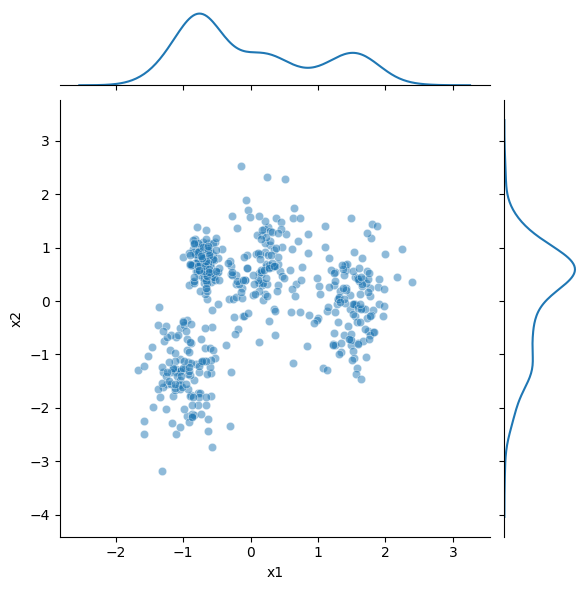

In [5]:
g = sns.JointGrid(data= X_scaled, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha= 0.5)
g.plot_marginals(sns.kdeplot);

Based on the scatterplot there appears to be 3 or 4 clusters. Examining the density plot for x1, it appears there are be 4 clusters as the farthest left peak is tall suggesting more than one cluster while there are two other areas that somewhat peak in the density plot. The density plot for x2 suggest more like 3 clusters as highest peak most likely contains 2 clusters and there is one additional peak. The scatterplot also shows overlap in two of the clusters near the top of the plot. Similarly, the clusters do not appear to be of the same density as the top left blob is very compact, while the blob in the upper right is very dispearsed. 

### K-Means
K-Means assigns clusters by the proximity of a datapoint to a randomly choosen centroid of each of $k$ clusters. Centroids represent the center or the mean value of each cluster. Through an iterative process, these centroids and clusters are reassigned until stopping criteria is met. For more in-depth explaination of K-Means clustering, I recommend the <a href='https://www.youtube.com/watch?v=4b5d3muPQmA'>K-Means StatQuest</a> video.

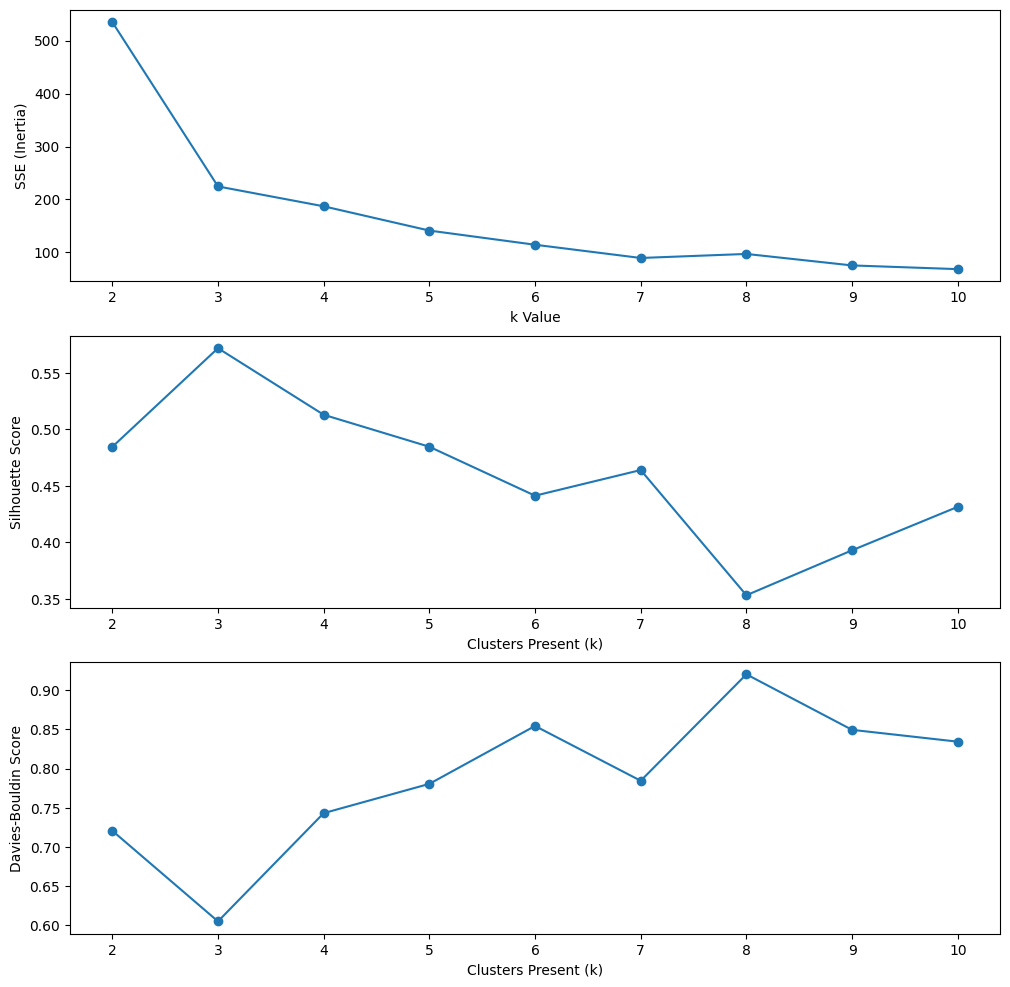

In [69]:
sse = np.empty((0, 2))
silhouette_score_by_k = np.empty((0, 2))
davies_bouldin_by_k = np.empty((0, 2))

for k in np.arange(2, 11, 1):
    kmeans = KMeans(n_clusters= k, init= 'k-means++').fit(X_scaled)
    sse = np.vstack([sse, np.array([k, kmeans.inertia_])])
    silhouette_score_by_k = np.vstack([silhouette_score_by_k, [k, silhouette_score(X= X_scaled, labels= kmeans.labels_)]])
    davies_bouldin_by_k = np.vstack([davies_bouldin_by_k, [k, davies_bouldin_score(X= X_scaled, labels= kmeans.labels_)]])


fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(12,12))

ax[0].plot(sse[:, 0], sse[:, 1], marker='o')
ax[0].set_xlabel('k Value')
ax[0].set_ylabel('SSE (Inertia)')
ax[0].set_xticks(np.arange(2, 11, 1))

ax[1].plot(silhouette_score_by_k[:, 0], silhouette_score_by_k[:, 1],marker='o')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_xlabel('Clusters Present (k)')
ax[1].set_xticks(np.arange(2, 11, 1))

ax[2].plot(davies_bouldin_by_k[:, 0], davies_bouldin_by_k[:, 1],marker='o')
ax[2].set_ylabel('Davies-Bouldin Score')
ax[2].set_xlabel('Clusters Present (k)')
ax[2].set_xticks(np.arange(2, 11, 1))


plt.show()

The intertia method points to there being 3 clusters as the 'elbow' of the plot occurs at 3 or 4. Similarly, the maximum of the silhouette score occurs at the 3 suggesting there are 3 clusters. The Davies-Bouldin score also points to there being 3 clusters as it's minimum occurs at 3. Based on the preponderance of evidence, the best $k$ to cluster with is 3 as all methods agree that 3 is the optimal number of clusters. 

In [31]:
optimal_kmeans = KMeans(n_clusters= 3, init= 'k-means++').fit(X_scaled)

### Gaussian Mixture Model
Gaussian Mixture Models assume that the data is a combination of several ($k$) gaussian distributions. Each datapoint is assigned to the most likely distribution. The parameters of the distributions are unknown. The model iterates until the correct parameters for each distribution is found and each datapoint is assigned to the most likely distribution. 

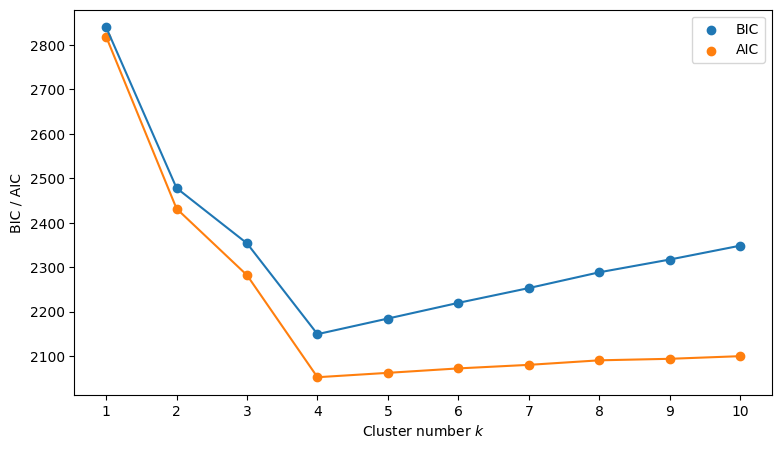

In [68]:
bic_aic = np.empty((0, 3))
for k in np.arange(start= 1, stop= 11, step= 1, dtype= int):
    gm = GaussianMixture(n_components= k).fit(X_scaled)
    bic_aic = np.vstack([bic_aic, np.array([k, gm.bic(X_scaled), gm.aic(X_scaled)])]) 
    
    
plt.figure(figsize= (9, 5))
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 1], label= 'BIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 1])
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 2], label= 'AIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 2])
plt.xlabel('Cluster number $k$')
plt.ylabel('BIC / AIC')
plt.xticks(ticks= np.linspace(1, 10, 10, dtype= int))
plt.legend()
plt.show()

Based on the BIC plot, the best $k$ is 4 since that is the minimum value. Simlarly, the AIC agrees that 4 is the best value for $k$ as it also reaches a minimum at 4. As both the AIC and BIC agree, the optimal number of clusters for a GMM is 4 clusters.

In [77]:
optimal_gm = GaussianMixture(n_components= 4).fit(X_scaled)

### DBSCAN
DBSCAN clustering is based on the density and groups datapoints into clusters that are tightly packed and marks outliers as noise. Clusters are determined by densly populated areas in the data space and separated by low density areas. This allows DBSCAN to model no circular clusters unlike the other two methods. 

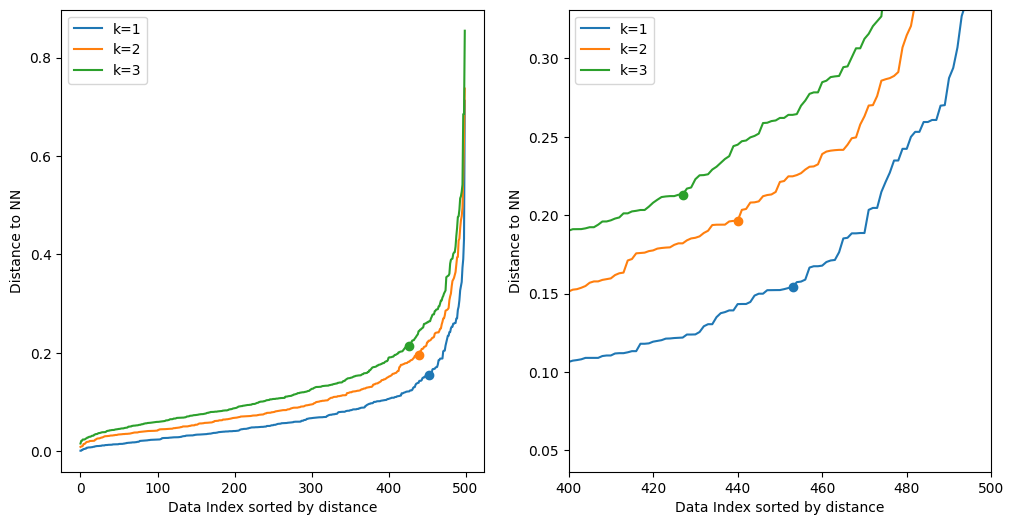

min_samples = 4.0 and epsilon = 0.21318468983485075


In [13]:
neighbors = 4
nbrs = NearestNeighbors(n_neighbors= neighbors).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

opt_esp_minpts = np.empty((0, 3))
fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, figsize= (12, 6))
for n in np.arange(1, neighbors):
    
    temp_distances = np.sort(distances[:, n])

    lndf = np.linspace(start= 0, stop= 1, num= int(temp_distances.shape[0]))
    scaled_dist = (temp_distances - temp_distances.min()) / (temp_distances.max() - temp_distances.min())
    
    distA = np.concatenate([lndf, scaled_dist]).reshape(2, -1).T
    distB = np.concatenate([lndf, lndf]).reshape(2, -1).T
    
    all2all = cdist(XA = distA, XB= distB)
    idx_opt = all2all.min(axis= 1).argmax()
    
    opt_esp_minpts = np.vstack([opt_esp_minpts, np.array([n, idx_opt, temp_distances[idx_opt]])]) 
    
    ax1.plot(temp_distances, label= f'k={n}')
    ax1.scatter(x= idx_opt, y= temp_distances[idx_opt])
    
    ax2.plot(temp_distances, label= f'k={n}')
    ax2.scatter(x= idx_opt, y= temp_distances[idx_opt])
    
    
eps_delta = opt_esp_minpts[:, 2].max() - opt_esp_minpts[:, 2].min()

ax2.set_xlim([np.floor(opt_esp_minpts[:, 1].min() / 100) * 100, 
              int(temp_distances.shape[0])])
ax2.set_ylim([opt_esp_minpts[:, 2].min() - 2*eps_delta,
              opt_esp_minpts[:, 2].max() + 2*eps_delta])    
ax1.legend()
ax1.set_xlabel('Data Index sorted by distance')
ax1.set_ylabel('Distance to NN')
ax2.legend()
ax2.set_xlabel('Data Index sorted by distance')
ax2.set_ylabel('Distance to NN')


plt.show()
print(f'min_samples = {opt_esp_minpts[-1, 0] + 1} and epsilon = {opt_esp_minpts[-1, 2]}')

Since the data is two dimensional, the suggestion is to use 4 samples as the minimal sample value. By examining the elbow plot, it appears that the elbow occurs slighly after the 0.2 which is confirmed by the calculation of the epsilon. The optimal epsilon value based on this evidence is 0.21318468983485075. 

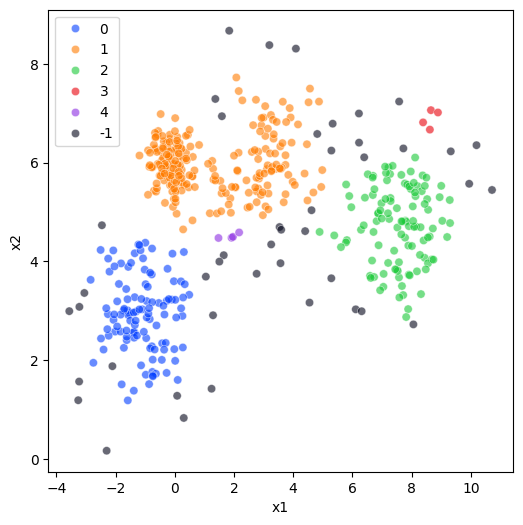

In [ ]:
dbscan = DBSCAN(min_samples= 4, eps= opt_esp_minpts[-1, 2]).fit(X_scaled)
# dbscan = DBSCAN(min_samples= int(opt_esp_minpts[-1, 0]) + 1, eps= 0.13).fit(df)
labels_db = dbscan.labels_
fig, ax = plt.subplots(nrows= 1, ncols= 1, figsize= (6, 6))
sns.scatterplot(data= df[dbscan.labels_ > -1], x= 'x1', y= 'x2', hue= labels_db[dbscan.labels_ > -1], alpha= 0.6, palette= 'bright')
sns.scatterplot(data= df[dbscan.labels_ == -1], x= 'x1', y= 'x2', hue= labels_db[dbscan.labels_ == -1], alpha= 0.6, palette= 'rocket')
plt.show()

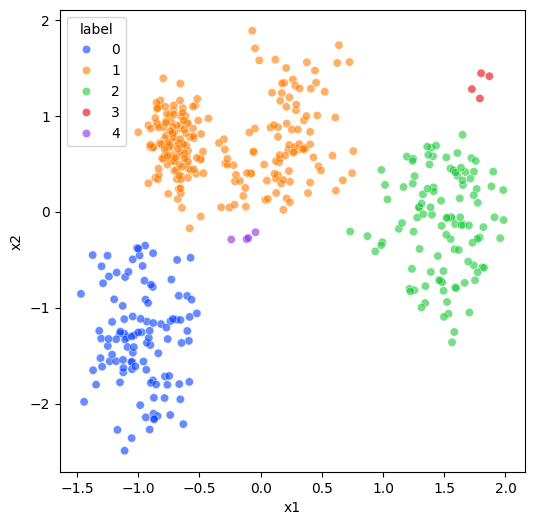

In [46]:
dbscan_df = X_scaled.copy()
dbscan_df['label'] = dbscan.labels_
dbscan_df = dbscan_df[dbscan_df.label != -1]

fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=dbscan_df, x='x1', y='x2', hue='label', alpha=0.6, palette='bright')
plt.show()

By examining the plots, it appears that there are several smaller clusters which could possibly be part of a larger cluster with the by increasing the value of the epsilon hyperparameter slightly. For example the purple cluster, or the cluster with the label 4 could be part of the orange cluster or the cluster with label 1 if the epsilon value were increased slightly. Similarly, by slightly increasing the epsilon value several outlier values would likely become part of a larger cluster. The clustering could benefit from a slight change to the value of epsilon.

### Model Evaluation

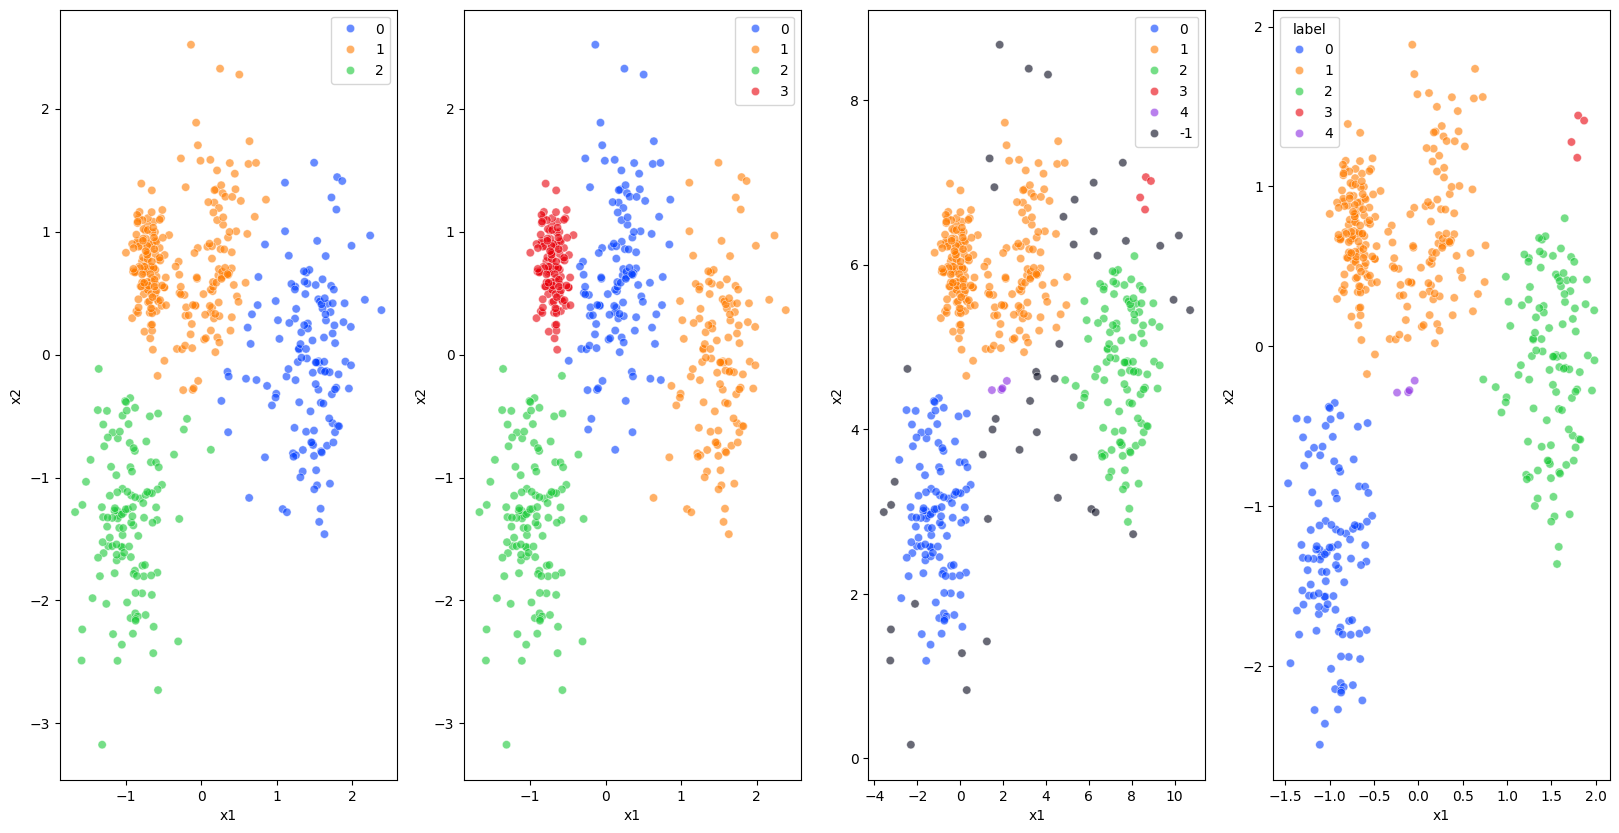

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,10))

sns.scatterplot(data=X_scaled, x='x1', y='x2', hue=optimal_kmeans.labels_, alpha=0.6, palette='bright', ax=ax[0])
sns.scatterplot(data=X_scaled, x='x1', y='x2', hue=optimal_gm.predict(X_scaled),alpha=0.6, palette='bright', ax=ax[1])
sns.scatterplot(data= df[dbscan.labels_ > -1], x= 'x1', y= 'x2', hue= labels_db[dbscan.labels_ > -1], alpha= 0.6, palette= 'bright',ax=ax[2])
sns.scatterplot(data= df[dbscan.labels_ == -1], x= 'x1', y= 'x2', hue= labels_db[dbscan.labels_ == -1], alpha= 0.6, palette= 'rocket',ax=ax[2])
sns.scatterplot(data=dbscan_df, x='x1', y='x2', hue='label', alpha=0.6, palette='bright', ax=ax[3])
plt.show()

Visually, the Gaussian Mixture Method appears to have the best clustering from the plots. For the most part the clusters are compact and well separated which implies a good clustering. All three methods identified a cluster in the upper left and the upper right. The upper left cluster remained a large cluster for both DBSCAN and K-Means, while it was broken into 2 by the GMM making both clusters more compact than the larger cluster of its counterparts.


Before beginning the analysis, the I stated that the blobs appeared to have different densities as some were more dispearsed possibly indicating fewer constituents while others were more compact potentially indicating higher number of constituents. This assessment appears to hold as DBSCAN struggled with identifying clusters more than the other methods and had a high number of outliers. Similarly, K-Means identified 3 clusters as the optimal number of clusters while the GMM identified 4, both of which appeared in the assement of the density plots. Since DBSCAN is density based, it makes sense that it had more difficulty with the different densities of the clusters. Based on the clustering from all three models, my assessment about overlap in the blobs does hold as for the most part the clusters are well separated. There are some clusters that are closer together, particularly in the GMM plot. However, for the most part there is minimal overlap.

In [78]:
metrics = pd.DataFrame([{'Silhouette Score':silhouette_score(X= X_scaled, labels= optimal_kmeans.labels_), 'Davies-Bouldin Index': davies_bouldin_score(X=X_scaled, labels=optimal_kmeans.labels_)},
              {'Silhouette Score':silhouette_score(X=X_scaled, labels=optimal_gm.predict(X_scaled)), 'Davies-Bouldin Index': davies_bouldin_score(X=X_scaled, labels=optimal_gm.predict(X_scaled))},
              {'Silhouette Score': silhouette_score(X=X_scaled, labels=dbscan.labels_), 'Davies-Bouldin Index': davies_bouldin_score(X=X_scaled, labels=dbscan.labels_)},
              {'Silhouette Score': silhouette_score(X=dbscan_df[['x1','x2']], labels=dbscan_df['label']), 'Davies-Bouldin Index': davies_bouldin_score(X=dbscan_df[['x1','x2']], labels=dbscan_df['label'])}],index=['K-Means', 'Gaussian Mixtures', 'DBSCAN w/ Outliers', 'DBSCAN w/o Outliers'])

metrics

,Silhouette Score,Davies-Bouldin Index
K-Means,0.571856,0.605149
Gaussian Mixtures,0.489827,0.785072
DBSCAN w/ Outliers,0.280937,2.423834
DBSCAN w/o Outliers,0.365152,0.538384


Based on the Silhouette score, K-Means performed best as it had the score closest to 1 at 0.572 while the DBSCAN with outliers performed worst with a score of 0.281. Accoreding to the Davies-Bouldin score, the DBSCAN without outliers performed best as it had the lowest score of 0.538 while the GMM performed worst with a score of 0.785. Based on the visual assement, it would seem that GMM should be the best cluster method. However, based on how the metrics are calculated it makes sense that the GMM would have the worst Davies-Bouldin score since there are several clusters which have small distances between their centroid which causes a higher DBI value. Similarly, for the silhouette score with the distances of some points being closer than others the separation of the clusters is not as strong as it could be. Therefore, the scores make sense despite the visual assement. 

The reason for the disagreement between the metrics is that while both are used to asssess the cohesion and separation of the clusters they calculate this differently. The silhouette score is based on the distance of the instance to every other instance in the cluster and its nearest cluster while the Davies-Bouldin index is based on the distance to the centroid and the distance of the centroid of the current cluster to the centroid of its nearest cluster. This means the DBI score focuses more on the position of the centroids while the silhouette score focuses more on all points of the clusters. The silhouette score is difference of the average inter-cluster distance and the average intra-cluster distance divided the largest of the two while the DBI is the sum of the compactness of the the cluster and its nearest neighbor and is always divided by the separation of the clusters. This means that both clusters need to be compact for the DBI while the other clusters simply need to be far away for the silhouette score. 